# Load reviews and import modules

In [1]:
with open('../datasets/imdb_reviews.pcl2', 'rb') as pcl_file:
    import pickle
    dataset = pickle.load(pcl_file)

In [2]:
import numpy as np
import pandas as pd

---

# Bag Of Words

## Vectorize the reviews

Whole dataset contains `N` distinct words, so each review turns into a vector with `N` components, in which each coordinate represents the number of occurences of corresponding word in the review.

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1))
review_codes = vectorizer.fit_transform(dataset['review'].values)

## Calculate co-occurence matrix

The number of times two particular words occur in the same review can be calculated via multiplying transposed matrix of review codes and itself. 

In [4]:
# coo_matrix = review_codes.T * review_codes

## Find the most frequent words (of length more than 3) and their codes

In [7]:
from keras.utils import np_utils

nbs_occur = np.asarray(review_codes.sum(axis=0)).ravel()
feat_names = vectorizer.get_feature_names()

nb_top = 20
sz = review_codes.shape[1]

pairs = [x for x in zip(nbs_occur, feat_names) if len(x[1]) > 3]
top_pairs = sorted(pairs, reverse=True)[:nb_top]
top_words = [x[1] for x in top_pairs]
top_word_codes = np_utils.to_categorical([vectorizer.vocabulary_.get(x) for x in top_words], nb_classes=sz)

Using Theano backend.


## Use SVD and transform 20 most frequent words into 2D vectors

In [27]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD()
svd.fit(review_codes)
top_svd = svd.transform(top_word_codes)

## Visualize 20 most frequent words as 2D points

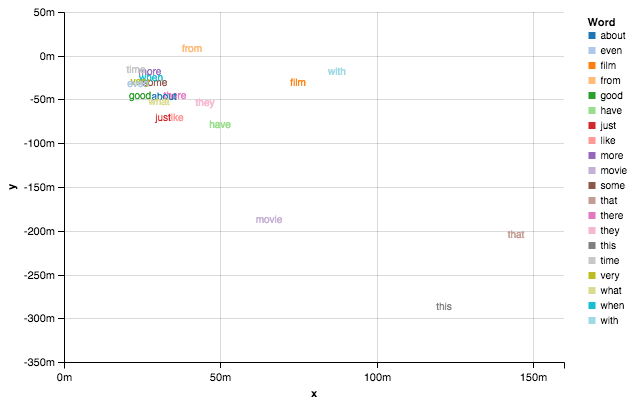

In [28]:
from altair import *

svd_tidy = pd.DataFrame(top_svd, columns=['x', 'y'])
svd_tidy['word'] = top_words

Chart(svd_tidy).mark_text().encode(
    x='x',
    y='y',
    color=Color('word', title='Word', scale=Scale(range='category20')),
    text='word'
)

---

# Word2vec

## Reorganize thedata

In [29]:
import nltk.data

tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [30]:
def review2sentences(review):
    sentences = tokenizer.tokenize(review.strip().decode('utf-8'))
    return [s.split() for s in sentences if len(s) > 0]

sentences = []
for r in dataset['review']:
    sentences += review2sentences(r)

## Train the model

In [16]:
from gensim.models import word2vec

nb_features = 100
nb_workers = 4

w2v_model = word2vec.Word2Vec(sentences, workers=nb_workers, size=nb_features)

In [17]:
w2v_model.init_sims(replace=True)

## Reduce dimensionality with TSNE

Use only 20 words to fit TSNE model, because otherwise MemoryError occurs.

In [47]:
from sklearn.manifold import TSNE

svd_assist = TruncatedSVD(n_components=5)
lower_dim = svd_assist.fit_transform(w2v_model.syn0)

tsne_model = TSNE()
top_tsne = tsne_model.fit_transform(np.array([w2v_model[w] for w in top_words]))

## Visualize 20 most frequent words as 2D points

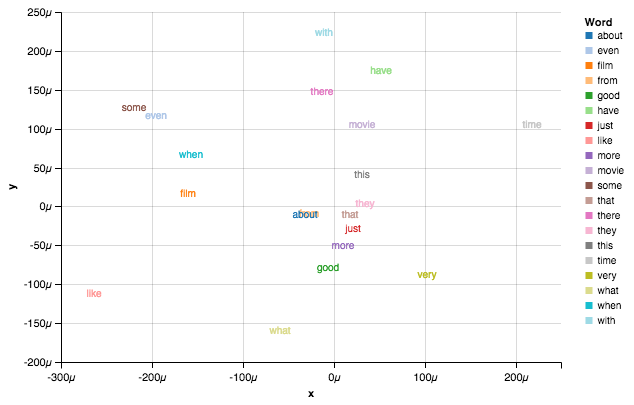

In [48]:
from altair import *

tsne_tidy = pd.DataFrame(top_tsne, columns=['x', 'y'])
tsne_tidy['word'] = top_words

Chart(tsne_tidy).mark_text().encode(
    x='x',
    y='y',
    color=Color('word', title='Word', scale=Scale(range='category20')),
    text='word'
)